Create a research and summarization agent using LangGraph. The agent should process user
queries by determining whether they require reasoning from an LLM, web research, or retrieval
from a knowledge base. The agent should leverage multiple specialized sub-agents to generate
well-structured responses.
The system should include:
1. Router Agent – Determines whether a query should be answered using the LLM, web
research, or retrieval-augmented generation (RAG).
2. Web Research Agent – If the query requires up-to-date information, this agent performs
a web search and extracts relevant details.
3. RAG Agent – If the query is related to a predefined dataset (e.g. any dataset that you
have)
4. Summarization Agent – After gathering information, this agent synthesizes a final
structured response.

##### I will try to solve this problem using two ways 
##### Way 1 * Router/RaAct Pattern
##### Way 2 * Using MultAgent Pattern

##### Way 1 


In [1]:
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from pydantic import BaseModel,Field
from typing_extensions import TypedDict
from typing import Annotated,Literal,List,Any
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode,tools_condition
from IPython.display import display,Markdown,Image
import operator
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_community.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate

In [12]:
###### Defining LLMs, Tavily Search, LangSmith project and  their keys


In [2]:
from getpass import getpass
OPENAI_KEY = getpass('Enter API key')

Enter API key ········


In [3]:
from getpass import getpass
TAVILY_API_KEY = getpass('Enter API key')

Enter API key ········


In [4]:
from getpass import getpass 
LANGSMITH_API_KEY = getpass("Enter your LangSmith API key (https://smith.langchain.com):\n")

Enter your LangSmith API key (https://smith.langchain.com):
 ········


In [5]:
 import os 
os.environ["LANGSMITH_API_KEY"] = LANGSMITH_API_KEY

In [6]:
 
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = 'Assignment_Advance_LangGraph'

In [7]:

os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

In [8]:
llm = ChatOpenAI(model = 'gpt-4o')
open_ai_embed = OpenAIEmbeddings(model = 'text-embedding-ada-002')

In [60]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper  
from langchain_core.tools import tool 
tavily_search = TavilySearchAPIWrapper()
@tool #decorator 
def search_web(query:str,num_result=3):
    """ Given the user query, Search the web for that query. Useful for general information or general news"""
    results = tavily_search.raw_results(query = query,
                                        max_results=num_result,
                                        search_depth = 'advanced',
                                        include_raw_content=True 
                                         )
    return results 

In [13]:
#define the RAG document 
#Document Loader and Split 
csv_loader = CSVLoader(file_path="./Sample_csv.csv")
csv_docs = csv_loader.load()
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)
split_docs = text_splitter.split_documents(csv_docs)


In [14]:
split_docs[0]

Document(metadata={'source': './Sample_csv.csv', 'row': 0}, page_content='ID: 451\nIssue_Summary: Login failure after iOS update\nResolution_Text: Issue caused by an outdated OAuth token in v3.2. Solution was to clear the app cache and force a token refresh via the profile settings. Requires L2 intervention.\nTime_Hrs: 1.5\nTeam: L2 Tech Support')

In [15]:
kbDB = Chroma.from_documents(documents = split_docs,
                                   collection_name='kbdb',
                                  embedding=open_ai_embed,
                                  # need to set the distance function to cosine else it uses euclidean by default
                                  collection_metadata={"hnsw:space": "cosine"},
                                  persist_directory="./kbdb"
                                    )

In [16]:
kbDB.get()

{'ids': ['dedf6444-f9bf-4355-be47-fce836c1d236',
  '0f50a1e3-6df2-4cc5-a00b-926db03c689d',
  'cc1841d1-c724-4b78-a5fd-5733a94dedf4',
  'e5aee1cd-d8e1-4379-967d-2e06b0f76d3c',
  '8b342566-be26-466f-91d9-5a51d44b0307',
  '01664d08-b9ac-4ee1-a847-c388a973a47b',
  'c0407eab-6b9e-45e1-bf82-5e48a34cf15a',
  'bbfabb39-ccbc-4aeb-ba81-a5763aa51c33',
  'b8c8df39-4931-499c-9aaa-3f3e26cb9cc6',
  'd3f24e3e-35f8-4ca6-8a82-192209919eb1',
  '56d59af4-ca15-4946-bc1b-db494a499d87',
  'c5248b9c-89ba-420f-b535-7b2b14787788',
  'a0c78afc-c1f4-4b99-b758-6916ee45c0ea',
  'a81867c6-7f60-49bf-932a-f6116709afab',
  'be0a26bc-fce0-44d4-b8f2-263f3baf3af6',
  '5ff8a2b0-9de3-4122-88b8-84f5c6a36f51',
  '97d903d6-8876-4adb-bad8-39d1ef96231b',
  '21d7cb02-4750-427c-8498-ffc19cf0b96b',
  '2c66ba20-a2df-42a4-b598-2e675ac833be',
  '7df4dfe6-3773-4eca-8739-09fe735ebd20'],
 'embeddings': None,
 'documents': ['ID: 451\nIssue_Summary: Login failure after iOS update\nResolution_Text: Issue caused by an outdated OAuth token in

In [17]:
docSimilarityRetreiver = kbDB.as_retriever(search_type = "similarity",search_kwargs = {"k":1})

In [19]:
query = "IOS Update"
result = docSimilarityRetreiver.invoke(query)
result

[Document(metadata={'row': 0, 'source': './Sample_csv.csv'}, page_content='ID: 451\nIssue_Summary: Login failure after iOS update\nResolution_Text: Issue caused by an outdated OAuth token in v3.2. Solution was to clear the app cache and force a token refresh via the profile settings. Requires L2 intervention.\nTime_Hrs: 1.5\nTeam: L2 Tech Support')]

In [59]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
                        retriever = docSimilarityRetreiver,
                        name = 'retriever_Info_From_KnowledgeBase',
                        description = 'Search and return information from KnowledgeBase'
            
)

### creating Multi Agent System 

In [110]:
###### Supervisor Agent

In [99]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END
from langgraph.types import Command
from langgraph.graph.message import add_messages

members = ["web", "rag"]

SUPERVISOR_AGENT_PROMPT = f"""You are a supervisor tasked with managing a conversation 
                            between the following workers:
                              {members}.

                              Given the following user request, respond with the worker to act next.
                              Each worker will perform a task and respond with their results and status.
                              Analyze the results carefully and decide which worker to call next accordingly.
                              Remember 
                              web agent can search for information  If the query requires up-to-date information, this agent performs
                              a web search and extracts relevant details
                              and rag agent can serahc information if If the query is related to a our 
                              knowledgebase dataset
                              When finished, respond with FINISH."""


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal["web", "rag", "FINISH"]

class State(TypedDict):
    messages: Annotated[list, add_messages]
    next: str
    
def supervisor_node(state: State) -> Command[Literal["web", "rag", "__end__"]]:
    messages = [{"role": "system", "content": SUPERVISOR_AGENT_PROMPT},] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [100]:
#create Web serach sub agent 
# Create Financial Researcher Sub-Agent
from langgraph.prebuilt import create_react_agent
web_agent = create_react_agent(
    llm, tools=[search_web], 
              prompt="""You are a Advance Agent who excels in searching the web .
                                                        DO NOT do any math or coding.
                                                        Once your task is done report back to the supervisor."""
)

# create node function for financial researcher sub-agent
def web_search_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web")
            ]
        },
        goto="supervisor",
    )

/var/folders/31/gbjdmsz534l97s5pmcnljqm80000gn/T/ipykernel_2223/2397601363.py:4: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  web_agent = create_react_agent(


In [101]:
#create RAG sub agent 
from langgraph.prebuilt import create_react_agent
rag_agent = create_react_agent(
    llm, tools=[retriever_tool], 
              prompt="""You are a Advance Agent for the given user request serach the knodwledge base.
                                                        DO NOT do any math or coding.
                                                        Once your task is done report back to the supervisor."""
)

# create node function for financial researcher sub-agent
def Kb_node(state: State) -> Command[Literal["supervisor"]]:
    result = rag_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="rag")
            ]
        },
        goto="supervisor",
    )

/var/folders/31/gbjdmsz534l97s5pmcnljqm80000gn/T/ipykernel_2223/354598398.py:3: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  rag_agent = create_react_agent(


In [105]:
# build the agent graph
multibuilder = StateGraph(State)
multibuilder.add_edge(START, "supervisor")

multibuilder.add_node("supervisor", supervisor_node)

multibuilder.add_node("web", web_search_node)
multibuilder.add_node("rag", Kb_node)

MultieAgentGraph = multibuilder.compile()


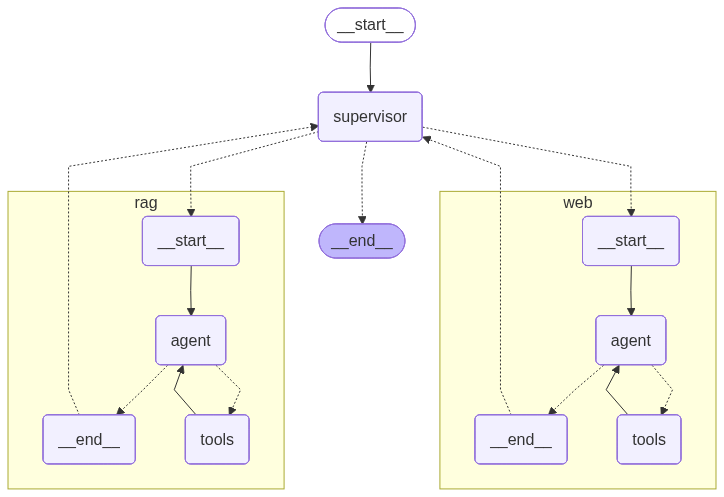

In [106]:
display(Image(MultieAgentGraph.get_graph(xray=True).draw_mermaid_png()))

In [111]:
### creating Single Agent System 

In [112]:
single_agent_prompt = """
You are a helpful AI Agent.

You will be provided below tools 
- Web Search tool : invoke this If the query requires up-to-date information, this agent performs
a web search and extracts relevant details
- Rag tool : invoke this if If the query is related to a the knowledge base dataset
"""
AGENT_SYS_PROMPT = SystemMessage(content=single_agent_prompt)

single_agent = create_react_agent(
    model=llm,
    tools=[retriever_tool,search_web],
    prompt=AGENT_SYS_PROMPT
)

/var/folders/31/gbjdmsz534l97s5pmcnljqm80000gn/T/ipykernel_2223/3583745841.py:11: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  single_agent = create_react_agent(


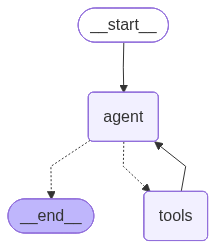

In [113]:
from IPython.display import Image

display(Image(single_agent.get_graph().draw_mermaid_png()))

In [116]:
init_message = "Duplicate charge on account"


In [119]:
for event in single_agent.stream(
    {"messages": [{"role": "user", "content": init_message}]},  # Properly formatted message with role and content
    stream_mode="values"
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Duplicate charge on account
================================== Ai Message ==================================

If you're experiencing a duplicate charge on your account, here are some steps you can take to resolve the issue:

1. **Review Your Transactions**: Double-check your account statement to ensure that the charge is indeed a duplicate.

2. **Contact the Merchant**: Reach out to the merchant where the charge originated. They may be able to resolve the issue directly by refunding the duplicate charge.

3. **Check for Pending Transactions**: Sometimes, pending transactions can appear as duplicates. Wait for a few days to see if one of the charges drops off.

4. **Contact Your Bank or Credit Card Issuer**: If the merchant is unable to help, contact your bank or credit card issuer. They can investigate the charge and may be able to reverse it.

5. **Dispute the Charge**: If necessary, you can formally dis

In [120]:
for event in MultieAgentGraph.stream(
    {"messages": [{"role": "user", "content": init_message}]},  # Properly formatted message with role and content
    stream_mode="values"
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Duplicate charge on account
================================ Human Message =================================

Duplicate charge on account
================================ Human Message =================================
Name: rag

I found information regarding a known issue with duplicate charges on accounts. It appears that there is a bug that duplicates Subscription_A payments when the Tier is set to Premium. The resolution for this issue is to manually void the duplicate charge and apply a 10% loyalty credit to the account. The Billing team typically handles this, and it takes about 0.5 hours to resolve.
================================ Human Message =================================
Name: rag

I found information regarding a known issue with duplicate charges on accounts. It appears that there is a bug that duplicates Subscription_A payments when the Tier is set to Premium. The resolution for this issu